In [1]:
'''
The Original AnimeGAN was written as a collection of python files 
and scripts. We reorganised it into a single Jupyter notebook, with
comments either at the top of each cell block, or within key 
functions.
'''

'\nThe Original AnimeGAN was written as a collection of Python files \nand scripts. We organised it into a single Jupyter notebook, with\ncomments either at the top of each cell block, or within key \nfunctions.\n'

In [2]:

'''
We placed the code here, which downloads the training dataset
into the current working directory. The real world domain data, 
with which we approximate the movie domain, interestingly comes 
from the original CycleGAN training dataset
'''

!ls 

DatesetURL='https://github.com/TachibanaYoshino/AnimeGAN/releases/download/dataset-1/dataset.zip'
ZIP_FILE='./dataset.zip'
TARGET_DIR='./dataset'

!rm -rf dataset
!wget -N $DatesetURL -O $ZIP_FILE
!unzip $ZIP_FILE -d $TARGET_DIR
!rm $ZIP_FILE

Streaming output truncated to the last 5000 lines.
  inflating: ./dataset/train_photo/2015-03-02 21_55_09.jpg  
  inflating: ./dataset/train_photo/2015-03-02 21_57_29.jpg  
  inflating: ./dataset/train_photo/2015-03-03 00_47_14.jpg  
  inflating: ./dataset/train_photo/2015-03-03 01_40_59.jpg  
  inflating: ./dataset/train_photo/2015-03-03 03_03_55.jpg  
  inflating: ./dataset/train_photo/2015-03-03 05_22_24.jpg  
  inflating: ./dataset/train_photo/2015-03-03 06_47_37.jpg  
  inflating: ./dataset/train_photo/2015-03-03 08_09_38.jpg  
  inflating: ./dataset/train_photo/2015-03-03 10_06_20.jpg  
  inflating: ./dataset/train_photo/2015-03-03 10_41_27.jpg  
  inflating: ./dataset/train_photo/2015-03-03 16_43_16.jpg  
  inflating: ./dataset/train_photo/2015-03-04 13_01_59.jpg  
  inflating: ./dataset/train_photo/2015-03-04 20_59_33.jpg  
  inflating: ./dataset/train_photo/2015-03-05 00_09_08.jpg  
  inflating: ./dataset/train_photo/2015-03-05 14_04_50.jpg  
  inflating: ./dataset/train_photo

In [3]:
'''
VGG19 is used in extracting high level features for the
generators content loss. The below lines upload VGG with
pretrained weights
'''

# Comment these lines if not using google drive
from google.colab import drive 
drive.mount('./gdrive') 

# VGG19
!mkdir vgg19_weight
VGG_FILE='./vgg19_weight/vgg19.npy'
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1U5HCRpZWAbDVLipNoF8t0ZHpwCRX7kdF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1U5HCRpZWAbDVLipNoF8t0ZHpwCRX7kdF" -O $VGG_FILE && rm -rf /tmp/cookies.

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).
mkdir: cannot create directory ‘vgg19_weight’: File exists
--2021-05-08 08:43:09--  https://docs.google.com/uc?export=download&confirm=rFVF&id=1U5HCRpZWAbDVLipNoF8t0ZHpwCRX7kdF
Resolving docs.google.com (docs.google.com)... 108.177.127.100, 108.177.127.102, 108.177.127.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.127.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-3k-docs.googleusercontent.com/docs/securesc/70afmqmog70kmi25t6vta23ru81ickp3/tkp7uqlua9n7jkkmu20qi80smkdqv43e/1620463350000/11222046922390799397/18131160684002239574Z/1U5HCRpZWAbDVLipNoF8t0ZHpwCRX7kdF?e=download [following]
--2021-05-08 08:43:09--  https://doc-04-3k-docs.googleusercontent.com/docs/securesc/70afmqmog70kmi25t6vta23ru81ickp3/tkp7uqlua9n7jkkmu20qi80smkdqv43e/1620463350000/11222046922390799397/18131160684002239574Z/1U5

In [4]:
# We require tensorflow 1.15, for AnimeGANplus to work

!pip install tensorflow==1.15
!pip install 'tensorflow-gpu==1.15'
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [5]:
# these libaries will be useful
from glob import glob
from tensorflow.contrib import slim
from tensorflow.python.client import device_lib

import argparse
import matplotlib.pyplot as plt
import numpy as np
import os,cv2
import random
import sys
import tensorflow as tf
import tensorflow.contrib as tf_contrib
import time 


tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

print(device_lib.list_local_devices())

# this allow tensorflow to use the GPU to the max
!export TF_FORCE_GPU_ALLOW_GROWTH=true

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13256770940146899649
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1862709138093028413
physical_device_desc: "device: XLA_CPU device"
]


In [6]:

# Basic helper functions for image loading and preprocessing


def read_img(image_path):
    '''
    Simple function to read an image and return as numpy array
    Conversion to RGB from BGR since we are using opencv
    '''
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    assert len(img.shape)==3
    return img

 
def calculate_average_brightness(img):
    '''
    This function computes the average brightness of pixels
    in a given imaage
    input: numpy array
    output: average brightness, along with brightness in each channel
    '''
    # begin with computing the average for each colorchannel
    B = img[..., 0].mean()
    G = img[..., 1].mean()
    R = img[..., 2].mean()

    brightness = 0.299 * R + 0.587 * G + 0.114 * B
    return brightness, B, G, R

def adjust_brightness_from_src_to_dst(dst, src,path=None,if_show=None, if_info=None):
    '''
    This function converts the `dst` image to have the same average
    brightness as the `src` image. The original function from the fork
    used opencv for saving the final result. However, since we use a
    Jupyter notebook, we can visualise in-cell with matplotlib  
    '''
    brightness1, B1, G1, R1 = calculate_average_brightness(src)
    brightness2, B2, G2, R2 = calculate_average_brightness(dst)
    brightness_difference = brightness1 / brightness2

    if if_info:
        print('Average brightness of original image', brightness1)
        print('Average brightness of target', brightness2)
        print('Brightness Difference between Original Image and Target', brightness_difference)

    # according to the average display brightness
    dstf = dst * brightness_difference

    # to limit the results and prevent crossing the border,
    # it must be converted to uint8, otherwise the default result is float32, and errors will occur.
    dstf = np.clip(dstf, 0, 255)
    dstf = np.uint8(dstf)

    ma,na,_ = src.shape
    mb,nb,_ = dst.shape
    result_show_img = np.zeros((max(ma, mb), 3 * max(na, nb), 3))
    result_show_img[:mb, :nb, :] = dst
    result_show_img[:ma, nb:nb + na, :] = src
    result_show_img[:mb, nb + na:nb + na + nb, :] = dstf
    result_show_img = result_show_img.astype(np.uint8)

    # This block was added in AnimeGAN pluss
    if if_show:
        plt.figure(figsize=(15, 4)) 
        plt.imshow(result_show_img)
        if path != None:
            plt.savefig(path,dpi=500)
        plt.show() 

    return dstf


# Image loading and manipulation
val_files = glob('./dataset/{}/*.*'.format('val'))
len(val_files)
idx = random.randrange(len(val_files)-1)
print(idx)
show_id = idx

def preprocessing(img, size):
    '''
    If the image shape is smaller than required,
    resize it to a factor of 32 and return a scaled 
    normalised version of the image 
    '''
    h, w = img.shape[:2]
    if h <= size[0]:
        h = size[0]
    else:
        x = h % 32
        h = h - x

    if w < size[1]:
        w = size[1]
    else:
        y = w % 32
        w = w - y
    img = cv2.resize(img, (w, h))
    return img/127.5 - 1.0


def load_test_data(image_path, size):
    '''
    This function loads an individual image for testing
    Conversion to RGB from BGR since we are using opencv
    '''
    img = cv2.imread(image_path).astype(np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocessing(img,size)
    img = np.expand_dims(img, axis=0)
    return img

def save_images(images, image_path, photo_path = None):
    '''
    This function is used in training and testing and is 
    how we save output images of the generator
    '''
    fake = inverse_transform(images.squeeze())
    if photo_path:
        return imsave(adjust_brightness_from_src_to_dst(fake, read_img(photo_path)),  image_path)
    else:
        return imsave(fake, image_path)
    
    
def inverse_transform(images):
    ''' 
    From the original repo: The calculation of floating-point
    numbers is inaccurate, and the range of pixel values must 
    be limited to the boundary, otherwise, image distortion or 
    artifacts will appear during display.
    '''
    images = (images + 1.) / 2 * 255
    images = np.clip(images, 0, 255)
    return images.astype(np.uint8)


def show_image(images_real, images_fake):
    '''
    This function to help with visualising
    a randomly selected validation image ever epoch
    of training
    '''
    fake = inverse_transform(images_fake.squeeze())
    real = inverse_transform(images_real.squeeze()) 
    plt.figure(figsize=(30, 8)) 
    plt.subplot(1,2,1)
    plt.imshow(real)   
    plt.subplot(1,2,2)
    plt.imshow(fake) 
    plt.show()
    
    
def imsave(images, path):
    '''Simply saving an image'''
    return cv2.imwrite(path, cv2.cvtColor(images, cv2.COLOR_BGR2RGB))



crop_image = lambda img, x0, y0, w, h: img[y0:y0+h, x0:x0+w]
def random_crop(img1, img2, crop_H, crop_W):
    '''This function performs a simple random crop'''
    assert  img1.shape ==  img2.shape
    h, w = img1.shape[:2]

    # The crop width cannot exceed the original image crop width
    if crop_W > w:
        crop_W = w
    
    # Crop height
    if crop_H > h:
        crop_H = h

    # Randomly generate the position of the upper left corner
    x0 = np.random.randint(0, w - crop_W + 1)
    y0 = np.random.randint(0, h - crop_H + 1)

    crop_1 = crop_image(img1, x0, y0, crop_W, crop_H)
    crop_2 = crop_image(img2, x0, y0, crop_W, crop_H)
    return crop_1,crop_2


def show_all_variables():
    '''Printing the names of trainable model variables'''
    model_vars = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_vars, print_info=True)
    print('G:')
    slim.model_analyzer.analyze_vars([var for var in tf.trainable_variables() if var.name.startswith('generator')], print_info=True)
 
def check_folder(log_dir):
    '''Creating a folder for use if it doesn't already exist'''
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    return log_dir

def str2bool(x):
    '''This function is used as input type of spectral norm'''
    return x.lower() in ('true')


  

36


dataset  gdrive  sample_data  samples  vgg19_weight
Average brightness of original image 188.6382914078125
Average brightness of target 40.00970735243056
Brightness Difference between Original Image and Target 4.714813076390894


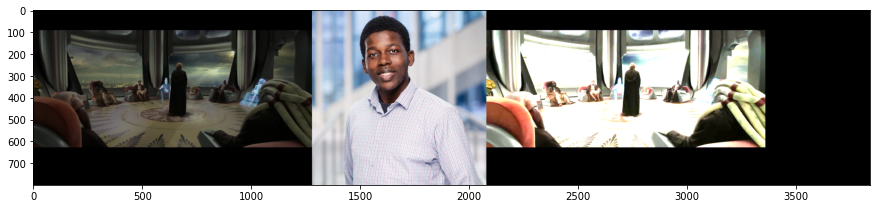

In [7]:
'''
Here is an example taking an scene from the Star Wars
film and giving it the same average brightness as Munachiso's
picture
'''
!ls
A = read_img('./samples/frame30.jpg')
B = read_img('./samples/munachiso.jpeg')

# adjusted = adjust_brightness_from_src_to_dst(A, B, path='resA.png')
adjusted = adjust_brightness_from_src_to_dst(A, B,if_show=True,if_info=True,path='../brightness_comparisons.pdf')


In [8]:
# Normalisation functions and activation functions
def lrelu(x, alpha=0.2):
    '''LReLU is the activation of choice through the network'''
    return tf.nn.leaky_relu(x, alpha)

 

def layer_norm(x, scope='layer_norm'):
    '''
    Unlike the original AnimeGANplus, we only need to 
    use layernorm instead of instance norm  
    '''
    return tf_contrib.layers.layer_norm(x,
                                        center=True, scale=True,
                                        scope=scope)
def l2_norm(v, eps=1e-12):
    '''Computation of L2 Norm, with eps to avoid 0 division'''
    return v / (tf.reduce_sum(v ** 2) ** 0.5 + eps)

def spectral_norm(w, iteration=1):
    '''
    According to the AnimeGAN v1 paper, spectral norm is used 
    to stabilize training of weights in each convolutional layer. See:
    https://calculus.subwiki.org/wiki/Spectral_norm
    https://christiancosgrove.com/blog/2018/01/04/spectral-normalization-explained.html
    https://www.paperswithcode.com/method/spectral-normalization 
    '''
    w_shape = w.shape.as_list()
    w = tf.reshape(w, [-1, w_shape[-1]])

    u = tf.get_variable("u", [1, w_shape[-1]], initializer=tf.truncated_normal_initializer(), trainable=False)

    u_hat = u
    v_hat = None
    for i in range(iteration):
        # power iteration; Usually iteration = 1 will be enough
        v_ = tf.matmul(u_hat, tf.transpose(w))
        v_hat = l2_norm(v_)

        u_ = tf.matmul(v_hat, w)
        u_hat = l2_norm(u_)

    sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))
    w_norm = w / sigma

    with tf.control_dependencies([u.assign(u_hat)]):
        w_norm = tf.reshape(w_norm, w_shape)

    return w_norm

def flatten(x) :
    '''
    Flattens inputs without affecting the batch size
    '''
    return tf.layers.flatten(x)
 

In [9]:
# The image data generator
class ImageGenerator(object):
    '''
    This class defines the custom image generator
    from AnimeGAN. It essentially loads the paths for 
    the training/testing images, and returns a tensorflow
    tf.data.dataset object which we can iterate through
    '''
    def __init__(self, image_dir,size, batch_size, data_mean, num_cpus = 16):
        self.paths = self.get_image_paths_train(image_dir)
        self.num_images = len(self.paths)
        self.num_cpus = num_cpus
        self.size = size
        self.batch_size = batch_size
        self.data_mean = data_mean

    def get_image_paths_train(self, image_dir):

        image_dir = os.path.join(image_dir)

        paths = []

        for path in os.listdir(image_dir):
            # Check extensions of filename
            if path.split('.')[-1] not in ['jpg', 'jpeg', 'png', 'gif']:
                continue

            # Construct complete path to anime image
            path_full = os.path.join(image_dir, path)

            # Validate if colorized image exists
            if not os.path.isfile(path_full):
                continue

            paths.append(path_full)

        return paths

    def read_image(self, img_path1):

        if 'style' in img_path1.decode() or 'smooth' in img_path1.decode():
            # color image1
            image1 = cv2.imread(img_path1.decode()).astype(np.float32)
            image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
            image1[:,:,0] += self.data_mean[2]
            image1[:,:,1] += self.data_mean[1]
            image1[:,:,2] += self.data_mean[0]

            # gray image2
            image2 = cv2.imread(img_path1.decode(),cv2.IMREAD_GRAYSCALE).astype(np.float32)
            image2 = np.asarray([image2,image2,image2])
            image2= np.transpose(image2,(1,2,0))

        else:
            # color image1
            image1 = cv2.imread(img_path1.decode()).astype(np.float32)
            image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

            image2 = np.zeros(image1.shape).astype(np.float32)

        return image1, image2

    def load_image(self, img1 ):
        image1, image2 = self.read_image(img1)
        processing_image1 = image1/ 127.5 - 1.0
        processing_image2 = image2/ 127.5 - 1.0
        return (processing_image1,processing_image2)

    def load_images(self):

        dataset = tf.data.Dataset.from_tensor_slices(self.paths)

        # Repeat indefinitely
        dataset = dataset.repeat()

        # Unform shuffle
        dataset = dataset.shuffle(buffer_size=len(self.paths))

        # Map path to image 
        dataset = dataset.map(lambda img: tf.py_func(
            self.load_image, [img], [tf.float32,tf.float32]),
                              self.num_cpus)

        dataset = dataset.batch(self.batch_size)

        img1,img2 = dataset.make_one_shot_iterator().get_next()

        return img1,img2

In [10]:
'''
In this cell, we define the loss functions used in calculating the overall
loss, specifically the color, grayscale, content, and adversarial losses.
Note that the presence of a grayscale adversarial loss in the discriminator
in addition to the grayscale style loss in the generator
'''

def L1_loss(x, y):
    loss = tf.reduce_mean(tf.abs(x - y))
    return loss

def L2_loss(x,y):
    size = tf.size(x)
    return tf.nn.l2_loss(x-y)* 2 / tf.to_float(size)

def Huber_loss(x,y):
    '''
    Huber Loss is used in the ccolor recconstruction loss,
    having softer gradients within a smaller neighborhood 
    than L1 loss
    '''
    return tf.losses.huber_loss(x,y)

def color_loss(con, fake):
    '''
    Images are converted from RGB to YUV, with L1 lloss used
    in Y channel and Huber loss used on chromatic components 
    which correspond to the U and V channels. Since L1 loss tends
    push error down to zero, due to having more uniform gradients,
    while the gradients of Huberloss soften for sufficiently small
    values
    '''
    con = rgb2yuv(con)
    fake = rgb2yuv(fake)

    return L1_loss(con[:,:,:,0], fake[:,:,:,0]) + Huber_loss(con[:,:,:,1],fake[:,:,:,1]) + Huber_loss(con[:,:,:,2],fake[:,:,:,2])

def rgb2yuv(rgb):
    """
    Convert RGB image into YUV https://en.wikipedia.org/wiki/YUV
    """
    rgb = (rgb + 1.0)/2.0 
    return tf.image.rgb_to_yuv(rgb)



def gram(x):
    shape_x = tf.shape(x)
    b = shape_x[0]
    c = shape_x[3]
    x = tf.reshape(x, [b, -1, c])
    return tf.matmul(tf.transpose(x, [0, 2, 1]), x) / tf.cast((tf.size(x) // b), tf.float32)

def con_loss(vgg, real, fake):

    vgg.build(real)
    real_feature_map = vgg.conv4_4_no_activation

    vgg.build(fake)
    fake_feature_map = vgg.conv4_4_no_activation

    loss = L1_loss(real_feature_map, fake_feature_map)

    return loss


def style_loss(style, fake):
    '''
    The grayscale style loss in the generator makes 
    use of Gram matrix for comparing feature distributions 
    extracted from generated images, against those 
    from grayscale training anime images.
    '''
    return L1_loss(gram(style), gram(fake))

def con_sty_loss(vgg, real, anime, fake):

    vgg.build(real)
    real_feature_map = vgg.conv4_4_no_activation

    vgg.build(fake)
    fake_feature_map = vgg.conv4_4_no_activation

    vgg.build(anime[:fake_feature_map.shape[0]])
    anime_feature_map = vgg.conv4_4_no_activation

    c_loss = L1_loss(real_feature_map, fake_feature_map)
    s_loss = style_loss(anime_feature_map, fake_feature_map)

    return c_loss,s_loss

def generator_loss(loss_func, fake):
    '''
    Four different kinds of adversarial losses were provided
    by AnimeGAN for experiments. For instance the lsgan is well
    known for reducing loss saturatinon compared to th orriginal 
    GAN log loss, which doesn't have additional penalisation for 
    misclassifications far away from the boundary
    '''
    fake_loss = 0

    if loss_func == 'wgan-gp' or loss_func == 'wgan-lp':
        fake_loss = -tf.reduce_mean(fake)

    if loss_func == 'lsgan' :
        fake_loss = tf.reduce_mean(tf.square(fake - 1.0))

    if loss_func == 'gan' or loss_func == 'dragan':
        fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(fake), logits=fake))

    if loss_func == 'hinge':
        fake_loss = -tf.reduce_mean(fake)

    loss = fake_loss

    return loss

def discriminator_loss(loss_func, real, gray, fake, real_blur):
    '''
    The discriminator loss is a sum of the four components, two of which
    represent to typical GAN loss components https://arxiv.org/pdf/1406.2661.pdf
    The other two terms are for grayscale and edge promotion. Four different
    options for adversarial losses were provided 
    '''
    real_loss = 0
    gray_loss = 0
    fake_loss = 0
    real_blur_loss = 0


    if loss_func == 'wgan-gp' or loss_func == 'wgan-lp':
        real_loss = -tf.reduce_mean(real)
        gray_loss = tf.reduce_mean(gray)
        fake_loss = tf.reduce_mean(fake)
        real_blur_loss = tf.reduce_mean(real_blur)

    if loss_func == 'lsgan' :
        real_loss = tf.reduce_mean(tf.square(real - 1.0))
        gray_loss = tf.reduce_mean(tf.square(gray))
        fake_loss = tf.reduce_mean(tf.square(fake))
        real_blur_loss = tf.reduce_mean(tf.square(real_blur))

    if loss_func == 'gan' or loss_func == 'dragan' :
        real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real), logits=real))
        gray_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(gray), logits=gray))
        fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(fake), logits=fake))
        real_blur_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(real_blur), logits=real_blur))

    if loss_func == 'hinge':
        real_loss = tf.reduce_mean(relu(1.0 - real))
        gray_loss = tf.reduce_mean(relu(1.0 + gray))
        fake_loss = tf.reduce_mean(relu(1.0 + fake))
        real_blur_loss = tf.reduce_mean(relu(1.0 + real_blur))

    loss = 1.7 * real_loss + 1.7 * fake_loss + 1.7 * gray_loss  +  0.8 * real_blur_loss

    return loss
    



VGG_MEAN = [103.939, 116.779, 123.68]
class Vgg19:
    '''
    The original VGG19 model is used, with pretrained weights
    to extract high level features, specifically from the conv4-4
    layer, for the content and grayscale style losses
    '''
    def __init__(self, vgg19_npy_path=VGG_FILE):

        if vgg19_npy_path is not None:
            self.data_dict = np.load(vgg19_npy_path, encoding='latin1', allow_pickle=True).item()
            print("npy file loaded ------- ",vgg19_npy_path)
        else:
            self.data_dict = None
            print("npy file load error!")
            sys.exit(1)

    def build(self, rgb, include_fc=False):
        """
        load variable from npy to build the VGG
        input format: bgr image with shape [batch_size, h, w, 3]
        scale: (-1, 1)
        """

        start_time = time.time()
        rgb_scaled = ((rgb + 1) / 2) * 255.0 # [-1, 1] ~ [0, 255]

        red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=rgb_scaled)
        bgr = tf.concat(axis=3, values=[blue - VGG_MEAN[0],
                                        green - VGG_MEAN[1],
                                        red - VGG_MEAN[2]])

        self.conv1_1 = self.conv_layer(bgr, "conv1_1")
        self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
        self.pool1 = self.max_pool(self.conv1_2, 'pool1')

        self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
        self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
        self.pool2 = self.max_pool(self.conv2_2, 'pool2')

        self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
        self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
        self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
        self.conv3_4 = self.conv_layer(self.conv3_3, "conv3_4")
        self.pool3 = self.max_pool(self.conv3_4, 'pool3')

        self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
        self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
        self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")

        self.conv4_4_no_activation = self.no_activation_conv_layer(self.conv4_3, "conv4_4")

        self.conv4_4 = self.conv_layer(self.conv4_3, "conv4_4")
        self.pool4 = self.max_pool(self.conv4_4, 'pool4')

        self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
        self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
        self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
        self.conv5_4 = self.conv_layer(self.conv5_3, "conv5_4")
        self.pool5 = self.max_pool(self.conv5_4, 'pool5')

        if include_fc:
            self.fc6 = self.fc_layer(self.pool5, "fc6")
            assert self.fc6.get_shape().as_list()[1:] == [4096]
            self.relu6 = tf.nn.relu(self.fc6)

            self.fc7 = self.fc_layer(self.relu6, "fc7")
            self.relu7 = tf.nn.relu(self.fc7)

            self.fc8 = self.fc_layer(self.relu7, "fc8")

            self.prob = tf.nn.softmax(self.fc8, name="prob")

            self.data_dict = None
        print(("build model finished: %fs" % (time.time() - start_time)))

    def avg_pool(self, bottom, name):
        return tf.nn.avg_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def max_pool(self, bottom, name):
        return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def conv_layer(self, bottom, name):
        with tf.variable_scope(name):
            filt = self.get_conv_filter(name)

            conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')

            conv_biases = self.get_bias(name)
            bias = tf.nn.bias_add(conv, conv_biases)

            relu = tf.nn.relu(bias)
            return relu

    def no_activation_conv_layer(self, bottom, name):
        with tf.variable_scope(name):
            filt = self.get_conv_filter(name)

            conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')

            conv_biases = self.get_bias(name)
            x = tf.nn.bias_add(conv, conv_biases)

            return x

    def fc_layer(self, bottom, name):
        with tf.variable_scope(name):
            shape = bottom.get_shape().as_list()
            dim = 1
            for d in shape[1:]:
                dim *= d
            x = tf.reshape(bottom, [-1, dim])

            weights = self.get_fc_weight(name)
            biases = self.get_bias(name)

            # Fully connected layer. Note that the '+' operation automatically
            # broadcasts the biases.
            fc = tf.nn.bias_add(tf.matmul(x, weights), biases)

            return fc

    def get_conv_filter(self, name):
        return tf.constant(self.data_dict[name][0], name="filter")

    def get_bias(self, name):
        return tf.constant(self.data_dict[name][1], name="biases")

    def get_fc_weight(self, name):
        return tf.constant(self.data_dict[name][0], name="weights")


In [11]:
'''
This cell contains the major blocks from the original 
AnimeGAN which are involved in building the overall
architecture. Note replacement of instance norm in 
all locations with layer normalisation.
'''

weight_init = tf.random_normal_initializer(mean=0.0, stddev=0.02)
weight_regularizer = None
def conv(x, channels, kernel=4, stride=2, pad=0, pad_type='zero', use_bias=True, sn=False, scope='conv_0'):
    with tf.variable_scope(scope):
        if (kernel - stride) % 2 == 0 :
            pad_top = pad
            pad_bottom = pad
            pad_left = pad
            pad_right = pad

        else :
            pad_top = pad
            pad_bottom = kernel - stride - pad_top
            pad_left = pad
            pad_right = kernel - stride - pad_left

        if pad_type == 'zero' :
            x = tf.pad(x, [[0, 0], [pad_top, pad_bottom], [pad_left, pad_right], [0, 0]])
        if pad_type == 'reflect' :
            x = tf.pad(x, [[0, 0], [pad_top, pad_bottom], [pad_left, pad_right], [0, 0]], mode='REFLECT')

        if sn :
            w = tf.get_variable("kernel", shape=[kernel, kernel, x.get_shape()[-1], channels], initializer=weight_init,
                                regularizer=weight_regularizer)
            x = tf.nn.conv2d(input=x, filter=spectral_norm(w),
                             strides=[1, stride, stride, 1], padding='VALID')
            if use_bias :
                bias = tf.get_variable("bias", [channels], initializer=tf.constant_initializer(0.0))
                x = tf.nn.bias_add(x, bias)

        else :
            x = tf.layers.conv2d(inputs=x, filters=channels,
                                 kernel_size=kernel, kernel_initializer=weight_init,
                                 kernel_regularizer=weight_regularizer,
                                 strides=stride, use_bias=use_bias)


        return x
 
 
# Helper functions from net/generator.py
def Conv2D(inputs, filters, kernel_size=3, strides=1, padding='VALID', Use_bias = None):
    if kernel_size == 3:
        inputs = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode="REFLECT")
    return tf.contrib.layers.conv2d(
        inputs,
        num_outputs=filters,
        kernel_size=kernel_size,
        stride=strides,
        biases_initializer= Use_bias,
        normalizer_fn=None,
        activation_fn=None,
        padding=padding)


def Conv2DNormLReLU(inputs, filters, kernel_size=3, strides=1, padding='VALID', Use_bias = None):
    x = Conv2D(inputs, filters, kernel_size, strides,padding=padding, Use_bias = Use_bias)
    x = layer_norm(x,scope=None)
    return lrelu(x)

def dwise_conv(input, k_h=3, k_w=3, channel_multiplier=1, strides=[1, 1, 1, 1],
                   padding='VALID', stddev=0.02, name='dwise_conv', bias=False):
    input = tf.pad(input, [[0, 0], [1, 1], [1, 1], [0, 0]], mode="REFLECT")
    with tf.variable_scope(name):
        in_channel = input.get_shape().as_list()[-1]
        w = tf.get_variable('w', [k_h, k_w, in_channel, channel_multiplier],regularizer=None,initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.depthwise_conv2d(input, w, strides, padding, rate=None, name=name, data_format=None)
        if bias:
            biases = tf.get_variable('bias', [in_channel * channel_multiplier],initializer=tf.constant_initializer(0.0))
            conv = tf.nn.bias_add(conv, biases)
        return conv

def Separable_conv2d(inputs, filters, kernel_size=3, strides=1, padding='VALID', Use_bias = None):
    if kernel_size==3 and strides==1:
        inputs = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode="REFLECT")
    if strides == 2:
        inputs = tf.pad(inputs, [[0, 0], [0, 1], [0, 1], [0, 0]], mode="REFLECT")
    return tf.contrib.layers.separable_conv2d(
        inputs,
        num_outputs=filters,
        kernel_size=kernel_size,
        depth_multiplier=1,
        stride=strides,
        biases_initializer=Use_bias,
        normalizer_fn=tf.contrib.layers.layer_norm,
        activation_fn=lrelu,
        padding=padding)

def Conv2DTransposeLReLU(inputs, filters, kernel_size=2, strides=2, padding='SAME', Use_bias = None):

    return tf.contrib.layers.conv2d_transpose(inputs,
        num_outputs=filters,
        kernel_size=kernel_size,
        stride=strides,
        biases_initializer=Use_bias,
        normalizer_fn=tf.contrib.layers.layer_norm,
        activation_fn=lrelu,
        padding=padding)

def Unsample(inputs, filters, kernel_size=3): 
    # An alternative to transposed convolution where we first resize, then convolve.
    # See http://distill.pub/2016/deconv-checkerboard/
    # For some reason the shape needs to be statically known for gradient propagation
    # through tf.image.resize_images, but we only know that for fixed image size, so we
    # plumb through a "training" argument
    new_H, new_W = 2 * tf.shape(inputs)[1], 2 * tf.shape(inputs)[2]
    inputs = tf.image.resize_images(inputs, [new_H, new_W])

    return Separable_conv2d(filters=filters, kernel_size=kernel_size, inputs=inputs)

def Downsample(inputs, filters = 256, kernel_size=3):
    # An alternative to transposed convolution where we first resize, then convolve.
    # See http://distill.pub/2016/deconv-checkerboard/
    # For some reason the shape needs to be statically known for gradient propagation
    # through tf.image.resize_images, but we only know that for fixed image size, so we
    # plumb through a "training" argument 

    new_H, new_W =  tf.shape(inputs)[1] // 2, tf.shape(inputs)[2] // 2
    inputs = tf.image.resize_images(inputs, [new_H, new_W])

    return Separable_conv2d(filters=filters, kernel_size=kernel_size, inputs=inputs)




class G_net(object):

    def __init__(self, inputs):

        with tf.variable_scope('G_MODEL'):

            with tf.variable_scope('b1'):
                inputs = Conv2DNormLReLU(inputs, 64)
                inputs = Conv2DNormLReLU(inputs, 64)
                inputs = Separable_conv2d(inputs,128,strides=2) + Downsample(inputs, 128)

            with tf.variable_scope('b2'):
                inputs = Conv2DNormLReLU(inputs, 128)
                inputs = Separable_conv2d(inputs, 128)
                inputs = Separable_conv2d(inputs, 256, strides=2) + Downsample(inputs, 256)

            with tf.variable_scope('m'):
                inputs = Conv2DNormLReLU(inputs, 256)
                inputs = self.InvertedRes_block(inputs, 2, 256, 1, 'r1')
                inputs = self.InvertedRes_block(inputs, 2, 256, 1, 'r2')
                inputs = self.InvertedRes_block(inputs, 2, 256, 1, 'r3')
                inputs = self.InvertedRes_block(inputs, 2, 256, 1, 'r4')
                inputs = self.InvertedRes_block(inputs, 2, 256, 1, 'r5')
                inputs = self.InvertedRes_block(inputs, 2, 256, 1, 'r6')
                inputs = self.InvertedRes_block(inputs, 2, 256, 1, 'r7')
                inputs = self.InvertedRes_block(inputs, 2, 256, 1, 'r8')
                inputs = Conv2DNormLReLU(inputs, 256)
            with tf.variable_scope('u2'):
                inputs = Unsample(inputs, 128)
                inputs = Separable_conv2d(inputs, 128)
                inputs = Conv2DNormLReLU(inputs, 128)

            with tf.variable_scope('u1'):
                inputs = Unsample(inputs,128)    # The number of the filters in this layer is 128 while it is 64 in the graph of the paper. Please refer to the code.
                inputs = Conv2DNormLReLU(inputs, 64)
                inputs = Conv2DNormLReLU(inputs, 64)


            out = Conv2D(inputs, filters =3, kernel_size=1, strides=1)
            self.fake = tf.tanh(out)


    def InvertedRes_block(self, input, expansion_ratio, output_dim, stride, name, reuse=False, bias=None):
        with  tf.variable_scope(name, reuse=reuse):
            # pw
            bottleneck_dim = round(expansion_ratio * input.get_shape().as_list()[-1])
            net = Conv2DNormLReLU(input, bottleneck_dim, kernel_size=1, Use_bias=bias)

            # dw
            net = dwise_conv(net, name=name)
            net = layer_norm(net,scope='1')
            net = lrelu(net)

            # pw & linear
            net = Conv2D(net, output_dim, kernel_size=1)
            net = layer_norm(net,scope='2')

            # element wise add, only for stride==1
            if (int(input.get_shape().as_list()[-1]) == output_dim) and stride == 1:
                net = input + net

            return net


# Helper function from net/discriminator.py
def D_net(x_init,ch, n_dis,sn, scope, reuse):
    channel = ch // 2
    with tf.variable_scope(scope, reuse=reuse):
        x = conv(x_init, channel, kernel=3, stride=1, pad=1, use_bias=False, sn=sn, scope='conv_0')
        x = lrelu(x, 0.2)

        for i in range(1, n_dis):
            x = conv(x, channel * 2, kernel=3, stride=2, pad=1, use_bias=False, sn=sn, scope='conv_s2_' + str(i))
            x = lrelu(x, 0.2)

            x = conv(x, channel * 4, kernel=3, stride=1, pad=1, use_bias=False, sn=sn, scope='conv_s1_' + str(i))
            x = layer_norm(x, scope='ins_norm_' + str(i))
            x = lrelu(x, 0.2)

            channel = channel * 2

        x = conv(x, channel * 2, kernel=3, stride=1, pad=1, use_bias=False, sn=sn, scope='last_conv')
        x = layer_norm(x, scope='last_ins_norm')
        x = lrelu(x, 0.2)

        x = conv(x, channels=1, kernel=3, stride=1, pad=1, use_bias=False, sn=sn, scope='D_logit')

        return x

In [17]:
'''
This AnimeGAN class contains the code for building the model
as well as training and testing phases. Loss computation, 
backpropagation and gradient descent are addressed here
'''
class AnimeGAN(object) :
    def __init__(self, sess, args):
        self.model_name = 'AnimeGAN'

        self.sess = sess
        self.checkpoint_dir = args.checkpoint_dir
        self.result_dir = args.result_dir
        self.log_dir = args.log_dir
        self.dataset_name = args.dataset
        self.data_mean = args.data_mean


        self.epoch = args.epoch
        self.init_epoch = args.init_epoch # args.epoch // 20

        self.gan_type = args.gan_type

        self.batch_size = args.batch_size

        self.save_freq = args.save_freq

        self.init_lr = args.init_lr
        self.d_lr = args.d_lr
        self.g_lr = args.g_lr


        """ Weight """
        self.g_adv_weight = args.g_adv_weight
        self.d_adv_weight = args.d_adv_weight
        self.con_weight = args.con_weight
        self.sty_weight = args.sty_weight
        self.color_weight = args.color_weight

        self.training_rate = args.training_rate
        self.ld = args.ld

        self.img_size = args.img_size
        self.img_ch = args.img_ch

        """ Discriminator """
        self.n_dis = args.n_dis
        self.ch = args.ch
        self.sn = args.sn

        self.sample_dir = os.path.join(args.sample_dir, self.model_dir)
        check_folder(self.sample_dir)

        self.real = tf.placeholder(tf.float32, [self.batch_size, self.img_size[0], self.img_size[1], self.img_ch], name='real_A')
        self.anime = tf.placeholder(tf.float32, [self.batch_size, self.img_size[0], self.img_size[1], self.img_ch], name='anime_A')
        self.anime_smooth = tf.placeholder(tf.float32, [self.batch_size, self.img_size[0], self.img_size[1], self.img_ch], name='anime_smooth_A')
        self.test_real = tf.placeholder(tf.float32, [1, None, None, self.img_ch], name='test_input')

        self.anime_gray = tf.placeholder(tf.float32, [self.batch_size, self.img_size[0], self.img_size[1], self.img_ch],name='anime_B')


        self.real_image_generator = ImageGenerator('./dataset/train_photo', self.img_size, self.batch_size, self.data_mean)
        self.anime_image_generator = ImageGenerator('./dataset/{}'.format(self.dataset_name + '/style'), self.img_size, self.batch_size, self.data_mean)
        self.anime_smooth_generator = ImageGenerator('./dataset/{}'.format(self.dataset_name + '/smooth'), self.img_size, self.batch_size, self.data_mean)
        self.dataset_num = max(self.real_image_generator.num_images, self.anime_image_generator.num_images)

        self.vgg = Vgg19()

        print()
        print("##### Information #####")
        print("# gan type : ", self.gan_type)
        print("# dataset : ", self.dataset_name)
        print("# max dataset number : ", self.dataset_num)
        print("# batch_size : ", self.batch_size)
        print("# epoch : ", self.epoch)
        print("# init_epoch : ", self.init_epoch)
        print("# training image size [H, W] : ", self.img_size)
        print("# g_adv_weight,d_adv_weight,con_weight,sty_weight,color_weight : ", self.g_adv_weight,self.d_adv_weight,self.con_weight,self.sty_weight,self.color_weight)
        print("# init_lr,g_lr,d_lr : ", self.init_lr,self.g_lr,self.d_lr)
        print(f"# training_rate G -- D: {self.training_rate} : 1" )
        print()

    ##################################################################################
    # Generator
    ##################################################################################

    def generator(self,x_init, reuse=False, scope="generator"):

        with tf.variable_scope(scope, reuse=reuse) :
            G = G_net(x_init)
            return G.fake

    ##################################################################################
    # Discriminator
    ##################################################################################

    def discriminator(self, x_init, reuse=False, scope="discriminator"):

            D = D_net(x_init, self.ch, self.n_dis, self.sn, reuse=reuse, scope=scope)

            return D

    ##################################################################################
    # Model
    ##################################################################################
    def gradient_panalty(self, real, fake, scope="discriminator"):
        if self.gan_type.__contains__('dragan') :
            eps = tf.random_uniform(shape=tf.shape(real), minval=0., maxval=1.)
            _, x_var = tf.nn.moments(real, axes=[0, 1, 2, 3])
            x_std = tf.sqrt(x_var)  # magnitude of noise decides the size of local region

            fake = real + 0.5 * x_std * eps

        alpha = tf.random_uniform(shape=[self.batch_size, 1, 1, 1], minval=0., maxval=1.)
        interpolated = real + alpha * (fake - real)

        logit, _= self.discriminator(interpolated, reuse=True, scope=scope)


        grad = tf.gradients(logit, interpolated)[0] # gradient of D(interpolated)
        grad_norm = tf.norm(flatten(grad), axis=1) # l2 norm

        GP = 0
        # WGAN - LP
        if self.gan_type.__contains__('lp'):
            GP = self.ld * tf.reduce_mean(tf.square(tf.maximum(0.0, grad_norm - 1.)))

        elif self.gan_type.__contains__('gp') or self.gan_type == 'dragan' :
            GP = self.ld * tf.reduce_mean(tf.square(grad_norm - 1.))

        return GP

    def build_model(self):

        """ Define Generator, Discriminator """
        self.generated = self.generator(self.real)
        self.test_generated = self.generator(self.test_real, reuse=True)


        anime_logit = self.discriminator(self.anime)
        anime_gray_logit = self.discriminator(self.anime_gray, reuse=True)

        generated_logit = self.discriminator(self.generated, reuse=True)
        smooth_logit = self.discriminator(self.anime_smooth, reuse=True)



        """ Define Loss """
        if self.gan_type.__contains__('gp') or self.gan_type.__contains__('lp') or self.gan_type.__contains__('dragan') :
            GP = self.gradient_panalty(real=self.anime, fake=self.generated)
        else :
            GP = 0.0

        # init pharse
        init_c_loss = con_loss(self.vgg, self.real, self.generated)
        init_loss = self.con_weight * init_c_loss
        
        self.init_loss = init_loss

        # gan
        # note that we pass the grayscale versions of anime training images to calculation of style loss
        c_loss, s_loss = con_sty_loss(self.vgg, self.real, self.anime_gray, self.generated)
        t_loss = self.con_weight * c_loss + self.sty_weight * s_loss + color_loss(self.real,self.generated) * self.color_weight

        g_loss = self.g_adv_weight * generator_loss(self.gan_type, generated_logit)
        d_loss = self.d_adv_weight * discriminator_loss(self.gan_type, anime_logit, anime_gray_logit, generated_logit, smooth_logit) + GP



        self.Generator_loss =  t_loss + g_loss
        self.Discriminator_loss = d_loss

        """ Training """
        t_vars = tf.trainable_variables()
        G_vars = [var for var in t_vars if 'generator' in var.name]
        D_vars = [var for var in t_vars if 'discriminator' in var.name]

        self.init_optim = tf.train.AdamOptimizer(self.init_lr, beta1=0.5, beta2=0.999).minimize(self.init_loss, var_list=G_vars)
        self.G_optim = tf.train.AdamOptimizer(self.g_lr , beta1=0.5, beta2=0.999).minimize(self.Generator_loss, var_list=G_vars)
        self.D_optim = tf.train.AdamOptimizer(self.d_lr , beta1=0.5, beta2=0.999).minimize(self.Discriminator_loss, var_list=D_vars)


        """" Summary """
        self.G_loss = tf.summary.scalar("Generator_loss", self.Generator_loss)
        self.D_loss = tf.summary.scalar("Discriminator_loss", self.Discriminator_loss)

        self.G_gan = tf.summary.scalar("G_gan", g_loss)
        self.G_vgg = tf.summary.scalar("G_vgg", t_loss)
        self.G_init_loss = tf.summary.scalar("G_init", init_loss)

        self.V_loss_merge = tf.summary.merge([self.G_init_loss])
        self.G_loss_merge = tf.summary.merge([self.G_loss, self.G_gan, self.G_vgg, self.G_init_loss])
        self.D_loss_merge = tf.summary.merge([self.D_loss])


    def train(self):
        # initialize all variables
        self.sess.run(tf.global_variables_initializer())

        # saver to save model
        self.saver = tf.train.Saver(max_to_keep=self.epoch)

        # summary writer
        self.writer = tf.summary.FileWriter(self.log_dir + '/' + self.model_dir, self.sess.graph)

        """ Input Image"""
        real_img_op, anime_img_op, anime_smooth_op  = self.real_image_generator.load_images(), self.anime_image_generator.load_images(), self.anime_smooth_generator.load_images()


        # restore check-point if it exits
        could_load, checkpoint_counter = self.load(self.checkpoint_dir)
        if could_load:
            start_epoch = checkpoint_counter + 1

            print(" [*] Load SUCCESS")
        else:
            start_epoch = 0

            print(" [!] Load failed...")

        # loop for epoch
        init_mean_loss = []
        mean_loss = []
        # training times , G : D = self.training_rate : 1
        j = self.training_rate
        for epoch in range(start_epoch, self.epoch):

            for idx in range(int(self.dataset_num / self.batch_size)): 

                anime, anime_smooth, real = self.sess.run([anime_img_op, anime_smooth_op, real_img_op])

                train_feed_dict = {
                    self.real:real[0],
                    self.anime:anime[0],
                    self.anime_gray:anime[1],
                    self.anime_smooth:anime_smooth[1]
                }

                if epoch < self.init_epoch :
                    # Init G
                    start_time = time.time()

                    real_images, generator_images, _, v_loss, summary_str = self.sess.run([self.real, self.generated,
                                                                             self.init_optim,
                                                                             self.init_loss, self.V_loss_merge], feed_dict = train_feed_dict)
                    self.writer.add_summary(summary_str, epoch)
                    init_mean_loss.append(v_loss)

                    print("Epoch: %3d Step: %5d / %5d  time: %f s init_v_loss: %.8f  mean_v_loss: %.8f" % (epoch, idx,int(self.dataset_num / self.batch_size), time.time() - start_time, v_loss, np.mean(init_mean_loss)))
                    if (idx+1)%200 ==0:
                        init_mean_loss.clear()
                else :
                    start_time = time.time()

                    if j == self.training_rate:
                        # Update D
                        _, d_loss, summary_str = self.sess.run([self.D_optim, self.Discriminator_loss, self.D_loss_merge],
                                                            feed_dict=train_feed_dict)
                        self.writer.add_summary(summary_str, epoch)

                    # Update G
                    real_images, generator_images, _, g_loss, summary_str = self.sess.run([self.real, self.generated,self.G_optim,
                                                                                              self.Generator_loss, self.G_loss_merge], feed_dict = train_feed_dict)
                    self.writer.add_summary(summary_str, epoch)

                    mean_loss.append([d_loss, g_loss])
                    if j == self.training_rate:

                        print(
                            "Epoch: %3d Step: %5d / %5d  time: %f s d_loss: %.8f, g_loss: %.8f -- mean_d_loss: %.8f, mean_g_loss: %.8f" % (
                                epoch, idx, int(self.dataset_num / self.batch_size), time.time() - start_time, d_loss, g_loss, np.mean(mean_loss, axis=0)[0],
                                np.mean(mean_loss, axis=0)[1]))
                    else:
                        print(
                            "Epoch: %3d Step: %5d / %5d time: %f s , g_loss: %.8f --  mean_g_loss: %.8f" % (
                                epoch, idx, int(self.dataset_num / self.batch_size), time.time() - start_time, g_loss, np.mean(mean_loss, axis=0)[1]))

                    if (idx + 1) % 200 == 0:
                        mean_loss.clear()

                    j = j - 1
                    if j < 1:
                        j = self.training_rate


            if (epoch + 1) >= self.init_epoch and np.mod(epoch + 1, self.save_freq) == 0:
                self.save(self.checkpoint_dir, epoch)

            if epoch >= self.init_epoch -1:
                """ Result Image """
                val_files = glob('./dataset/{}/*.*'.format('val'))
                save_path = './{}/{:03d}/'.format(self.sample_dir, epoch)
                check_folder(save_path)
                for i, sample_file in enumerate(val_files):
                    print('val: '+ str(i) + sample_file)
                    sample_image = np.asarray(load_test_data(sample_file, self.img_size))
                    test_real,test_generated = self.sess.run([self.test_real,self.test_generated],feed_dict = {self.test_real:sample_image} )
                    
                    if i==show_id:
                        show_image(test_real, test_generated)
                    
                    save_images(test_real, save_path+'{:03d}_a.png'.format(i), None)
                    # adjust_brightness_from_photo_to_fake
                    save_images(test_generated, save_path+'{:03d}_b.png'.format(i), sample_file) 


    @property
    def model_dir(self):

        return "{}_{}_{}_{}_{}_{}_{}_{}".format(self.model_name, self.dataset_name,
                                                   self.gan_type,
                                                   int(self.g_adv_weight), int(self.d_adv_weight), int(self.con_weight), int(self.sty_weight), int(self.color_weight))

    def save(self, checkpoint_dir, step):
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        self.saver.save(self.sess, os.path.join(checkpoint_dir, self.model_name + '.model'), global_step=step)

    def load(self, checkpoint_dir):
        print(" [*] Reading checkpoints...")
        checkpoint_dir = os.path.join(checkpoint_dir)

        ckpt = tf.train.get_checkpoint_state(checkpoint_dir) # checkpoint file information

        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path) # first line
            self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
            counter = int(ckpt_name.split('-')[-1])
            print(" [*] Success to read {}".format(ckpt_name))
            return True, counter
        else:
            print(" [*] Failed to find a checkpoint")
            return False, 0

    def test(self, test_files):
        tf.global_variables_initializer().run()

        self.saver = tf.train.Saver()
        could_load, checkpoint_counter = self.load(self.checkpoint_dir)
        self.result_dir = os.path.join(self.result_dir)
        check_folder(self.result_dir)

        if could_load :
            print(" [*] Load SUCCESS")
        else :
            print(" [!] Load failed...")

        # write html for visual comparison
        index_path = os.path.join(self.result_dir, 'index.html')
        index = open(index_path, 'w')
        index.write("<html><body><table><tr>")
        index.write("<th>name</th><th>input</th><th>output</th></tr>")

        for sample_file  in test_files :
            print('Processing the image: ', sample_file)
            sample_image = np.asarray(load_test_data(sample_file, self.img_size))
            image_path = os.path.join(self.result_dir,'{0}'.format(os.path.basename(sample_file)))

            fake_img = self.sess.run(self.test_generated, feed_dict = {self.test_real : sample_image})
            # adjust_brightness_from_photo_to_fake
            save_images(fake_img, image_path, sample_file)

            index.write("<td>%s</td>" % os.path.basename(image_path))

            index.write("<td><img src='%s' width='%d' height='%d'></td>" % (sample_file if os.path.isabs(sample_file) else (
                '../..' + os.path.sep + sample_file), self.img_size[1] +32, self.img_size[0]+32))
            index.write("<td><img src='%s' width='%d' height='%d'></td>" % (image_path if os.path.isabs(image_path) else (
                '../..' + os.path.sep + image_path), self.img_size[1]+32, self.img_size[0]+32))
            index.write("</tr>")

        index.close()

In [18]:
'''
For simplicity, we maintain the use of python's
argparser for setting the various hyperparamters
and arguments of the model. Be sure to adjust the
arguments to `result_dir` and `checkpoint_dir'
'''
desc = "Tensorflow implementation of AnimeGAN"
parser = argparse.ArgumentParser(description=desc)
parser.add_argument('--dataset', type=str, default='Shinkai', help='dataset_name')
parser.add_argument('--data_mean', type=list, default=[ 13.1360,-8.6698,-4.4661 ], help='data_mean(bgr) from data_mean.py')

parser.add_argument('--epoch', type=int, default=101, help='The number of epochs to run')
parser.add_argument('--init_epoch', type=int, default=1, help='The number of epochs for weight initialization')
parser.add_argument('--batch_size', type=int, default=6, help='The size of batch size')
parser.add_argument('--save_freq', type=int, default=1, help='The number of ckpt_save_freq')

parser.add_argument('--init_lr', type=float, default=2e-4, help='The learning rate')
parser.add_argument('--g_lr', type=float, default=2e-5, help='The learning rate')
parser.add_argument('--d_lr', type=float, default=4e-5, help='The learning rate')
parser.add_argument('--ld', type=float, default=10.0, help='The gradient penalty lambda')

parser.add_argument('--g_adv_weight', type=float, default=300.0, help='Weight about GAN')
parser.add_argument('--d_adv_weight', type=float, default=300.0, help='Weight about GAN')
parser.add_argument('--con_weight', type=float, default=1.5, help='Weight about VGG19') # 1.1 for Shinkai
# ------ the follow weight used in AnimeGAN
parser.add_argument('--sty_weight', type=float, default=2.8, help='Weight about style')
parser.add_argument('--color_weight', type=float, default=10.0, help='Weight about color')
# ---------------------------------------------
parser.add_argument('--training_rate', type=int, default=1, help='training rate about G & D')
parser.add_argument('--gan_type', type=str, default='lsgan', help='[gan / lsgan / wgan-gp / wgan-lp / dragan / hinge')

parser.add_argument('--img_size', type=list, default=[256,256], help='The size of image: H and W')
parser.add_argument('--img_ch', type=int, default=3, help='The size of image channel')

parser.add_argument('--ch', type=int, default=64, help='base channel number per layer')
parser.add_argument('--n_dis', type=int, default=3, help='The number of discriminator layer')
parser.add_argument('--sn', type=str2bool, default=True, help='using spectral norm')

parser.add_argument('--checkpoint_dir', type=str, default='gdrive/MyDrive/munachiso_frames/checkpoints',
                    help='Directory name to save the checkpoints')
parser.add_argument('--result_dir', type=str, default='gdrive/MyDrive/munachiso_frames/three_pics',
                    help='Directory name to save the generated images')
parser.add_argument('--log_dir', type=str, default='logs',
                    help='Directory name to save training logs')
parser.add_argument('--sample_dir', type=str, default='samples',
                    help='Directory name to save the samples on training')


_StoreAction(option_strings=['--sample_dir'], dest='sample_dir', nargs=None, const=None, default='samples', type=<class 'str'>, choices=None, help='Directory name to save the samples on training', metavar=None)

In [19]:
'''
We included `tf.reset_default_graph()` since tensorflow maintains variables
if we rerun this codeblock otherwise. see here  https://github.com/kratzert/finetune_alexnet_with_tensorflow/issues/8
To train the model, uncomment/use gan.train(), and to test the model, use gan.test() 
in the session block below. Currently set to testing mode. 
'''

tf.reset_default_graph() 
args, unknown = parser.parse_known_args()   
gpu_options = tf.GPUOptions(allow_growth=True) 
config=tf.ConfigProto(allow_soft_placement=True,device_count = {'GPU': 1},gpu_options=gpu_options)
main_session = tf.Session(config=config)
with main_session as sess:
        gan = AnimeGAN(sess, args)

        # build graph
        gan.build_model()
        
        # show network architecture
        show_all_variables()
        # Can change to gan.test when testing...
        # gan.train()
        print(" [*] Training finished!")
        # Can change to gan.train when trainning...
        test_files = glob('gdrive/MyDrive/munachiso_frames/three_pics/*.*')
        gan.test(test_files) 

npy file loaded -------  ./vgg19_weight/vgg19.npy

##### Information #####
# gan type :  lsgan
# dataset :  Shinkai
# max dataset number :  6656
# batch_size :  6
# epoch :  101
# init_epoch :  1
# training image size [H, W] :  [256, 256]
# g_adv_weight,d_adv_weight,con_weight,sty_weight,color_weight :  300.0 300.0 1.5 2.8 10.0
# init_lr,g_lr,d_lr :  0.0002 2e-05 4e-05
# training_rate G -- D: 1 : 1

build model finished: 0.117836s
build model finished: 1.040719s
build model finished: 0.106241s
build model finished: 0.105622s
build model finished: 0.110118s
---------
Variables: name (type shape) [size]
---------
generator/G_MODEL/b1/Conv/weights:0 (float32_ref 3x3x3x64) [1728, bytes: 6912]
generator/G_MODEL/b1/LayerNorm/beta:0 (float32_ref 64) [64, bytes: 256]
generator/G_MODEL/b1/LayerNorm/gamma:0 (float32_ref 64) [64, bytes: 256]
generator/G_MODEL/b1/Conv_1/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
generator/G_MODEL/b1/LayerNorm_1/beta:0 (float32_ref 64) [64, bytes: 256